<a href="https://colab.research.google.com/github/joshtan0710/pytorch_basics/blob/main/Sequence_to_sequence_neural_nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence to Sequence Neural Network in Pytorch 

In [1]:
import requests
url = 'https://download.pytorch.org/tutorial/data.zip'
data = requests.get(url)
with open("text.zip", "wb") as code:
    code.write(data.content)

In [2]:
import zipfile 

zip_ref = zipfile.ZipFile('/content/text.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Japanese.txt', 'data/names/Irish.txt', 'data/names/Arabic.txt', 'data/names/Vietnamese.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Russian.txt', 'data/names/Korean.txt', 'data/names/Italian.txt', 'data/names/Spanish.txt', 'data/names/Chinese.txt', 'data/names/English.txt', 'data/names/German.txt', 'data/names/French.txt', 'data/names/Polish.txt', 'data/names/Dutch.txt', 'data/names/Czech.txt', 'data/names/Greek.txt']
Slusarski


In [4]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [5]:
n_categories

18

In [67]:
# Creating the model architecture

import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)  # introduce sampling variety
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self,category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

# output_size is the number of letters
rnn = RNN(n_letters, n_hidden, n_letters)

In [71]:
# Setting Hyperparams

criterion = nn.NLLLoss()
learning_rate = 0.003
optimizer = torch.optim.SGD(rnn.parameters(), lr = learning_rate)

In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i]

In [23]:
randomChoice(all_categories)
index = all_categories.index('Irish')
tensor =  torch.zeros(1,n_categories)
tensor[0][index]=1
type(tensor)

torch.Tensor

In [65]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def categoryTensor(category):
  index = all_categories.index(category)
  tensor =  torch.zeros(1,n_categories)
  tensor[0][index]=1
  return tensor 

# why is target tensor not one-hot encoded? # e.g. tensor([20,  0, 17, 19,  4, 56])
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = categoryTensor(category)
    line_tensor = lineToTensor(line)
    target_tensor = targetTensor(line)
    return category_tensor, line_tensor, target_tensor

for i in range(1):
    category_tensor, line_tensor, target_tensor = randomTrainingExample()
    print(f' category shape : {category_tensor.shape}''\n\n' , f'line shape :{line_tensor.shape}' '\n\n', 'target shape :', target_tensor.shape)


 category shape : torch.Size([1, 18])

 line shape :torch.Size([8, 1, 57])

 target shape : torch.Size([8])


In [54]:
len(input_tensor)

6

In [69]:
# training loop

def train(input_tensor,category_tensor, target_tensor):
  hidden = rnn.initHidden()
  target_tensor.unsqueeze_(-1)
  loss = 0 

  for i in range(len(input_tensor)):
    output, hidden = rnn(category_tensor, input_tensor[i], hidden)

    # calculate loss at every step 
    l = criterion(output, target_tensor[i])

    loss += l

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return output, loss.item()/len(input_tensor)



In [73]:
# Initialise training 

current_loss = 0 
all_losses = []
plot_steps, print_steps = 500,5000
n_iters = 100000

for i in range(1,n_iters+1):
  category_tensor, line_tensor, target_tensor = randomTrainingExample()
  output, loss = train(line_tensor, category_tensor, target_tensor)
  
  current_loss += loss

  if (i) % plot_steps == 0:
    all_losses.append(current_loss/plot_steps)
    current_loss = 0
  
  if i % print_steps == 0:
    print(f'Epoch {i}: {loss:.4f}')




Epoch 5000: 1.8368
Epoch 10000: 2.6321
Epoch 15000: 2.1361
Epoch 20000: 2.9380
Epoch 25000: 2.0281
Epoch 30000: 2.1403
Epoch 35000: 1.8933
Epoch 40000: 2.1772
Epoch 45000: 2.5434
Epoch 50000: 2.5400
Epoch 55000: 2.7693
Epoch 60000: 1.9466
Epoch 65000: 2.6152
Epoch 70000: 2.8913
Epoch 75000: 2.1198
Epoch 80000: 2.6004
Epoch 85000: 2.1758
Epoch 90000: 1.8245
Epoch 95000: 3.2798
Epoch 100000: 3.1965


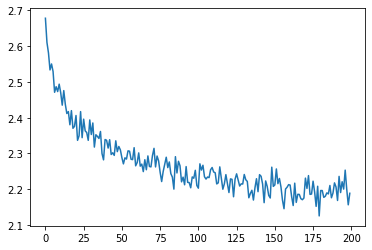

In [74]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [ ]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

In [ ]:
predict('Xiao Cai')


 >Xiao Cai
Japanese
